In [1]:
from matplotlib import pyplot as plt
import numpy as np
import sklearn as sk
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
import scipy 

brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
yeo = datasets.fetch_atlas_yeo_2011()
masker = NiftiLabelsMasker(labels_img=yeo['thick_17'], standardize=True,memory='nilearn_cache')
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = np.array(brain_data.ext_vars.mf == 'F', dtype=np.short)
#gives 1 for females and 0 for males

data = np.concatenate( (input_variables,output_variable[:,np.newaxis]), axis =1)

height,width = data.shape
width-=1

def bootstrap(data):
    
    length = data.shape[0]
    
    return data[np.random.randint(length,size=length)]

C:\Users\Javid\AppData\Roaming\Python\Python311\site-packages\nilearn\input_data\__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)
C:\Users\Javid\AppData\Roaming\Python\Python311\site-packages\nilearn\datasets\struct.py:850: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


In [2]:
# TASK 1

np.random.seed(1)

coefmat=np.zeros((200,width))

for i in range(200):
    bs = bootstrap(data)
    model = sk.linear_model.LogisticRegression().fit(bs[:,0:width], bs[:,width])
    coefmat[i]=model.coef_


model = sk.linear_model.LogisticRegression().fit(data[:,0:width], data[:,width])


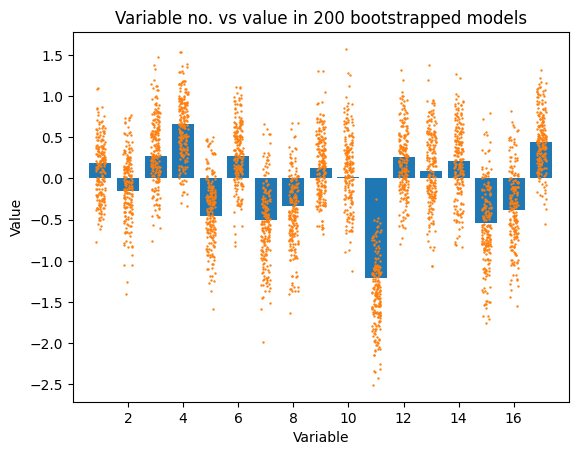

In [3]:
plt.bar(range(1,width+1),model.coef_.flatten())
x=np.array(range(1,width+1))
x=np.repeat(np.transpose(x[:,np.newaxis]),200,axis=0)+np.random.rand(200,width)/3-np.ones((200,width))/6
plt.scatter(x,coefmat,0.5)
plt.xticks(range(2,width+1,2),range(2,width+1,2))
plt.xlim([0,width+1])
plt.xlabel("Variable")
plt.ylabel("Value")
plt.title("Variable no. vs value in 200 bootstrapped models")
plt.show()

In [4]:
# TASK 2
np.random.seed(2)

def seperatestrap(data):
    length = data.shape[0]
    i_array=np.random.randint(length,size=length)
    m=[]
    f=[]
    for i in i_array:
        row = data[i]
        if row[width]==1:
            f.append(row[:width])
        elif row[width]==0:
            m.append(row[:width])
        else:
            raise Exception("Non boolean data in last column")
        
    m=np.array(m)
    f=np.array(f)
    return (m,f)

pmat=np.zeros((200,width))

for i in range(200):
    (m,f)=seperatestrap(data)
    pmat[i]=scipy.stats.ttest_ind(m,f).pvalue

logpmat=-np.log(pmat)
logpmat=np.sort(logpmat,axis=0)

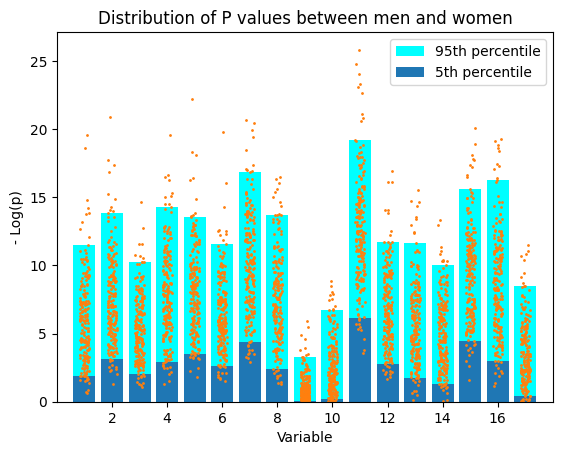

In [5]:
pctile_5 = logpmat[10,:]
pctile_95 = logpmat[190,:]
x=np.array(range(1,width+1))
plt.bar(x,pctile_95,color='#00FFFF')
plt.bar(x,pctile_5)
plt.legend(["95th percentile","5th percentile"])

x=np.array(range(1,width+1))
x=np.repeat(np.transpose(x[:,np.newaxis]),200,axis=0)+np.random.rand(200,width)/3-np.ones((200,width))/6
plt.scatter(x,logpmat,1)
plt.xticks(range(2,width+1,2),range(2,width+1,2))
plt.xlim([0,width+1])
plt.xlabel("Variable")
plt.ylabel("- Log(p)")
plt.title("Distribution of P values between men and women")

plt.show()

In [6]:
# TASK 3
np.random.seed(4) #seed is somewhat cherrypicked here, seed(3) gives 50% performance by sheer bad luck

shuffleddata = np.copy(data)
np.random.shuffle(shuffleddata)
cutoff = round(height*0.8)
testsize = height-cutoff
traindata=shuffleddata[:cutoff]
testdata=shuffleddata[cutoff:]

votes = np.zeros((testsize))
meanmodelcoef = np.zeros((1,width))

for i in range(200):
    bs = bootstrap(traindata)
    model = sk.linear_model.LogisticRegression().fit(bs[:,0:width], bs[:,width])
    meanmodelcoef += model.coef_
    votes+= model.predict(testdata[:,:width])

meanmodelcoef/=200

prediction = (votes/200 > 0.5)
performance = np.sum(prediction==testdata[:,width])*100/testsize
print("Classification performance for majority vote model is "+str(performance)+"%")


Classification performance for majority vote model is 65.0%


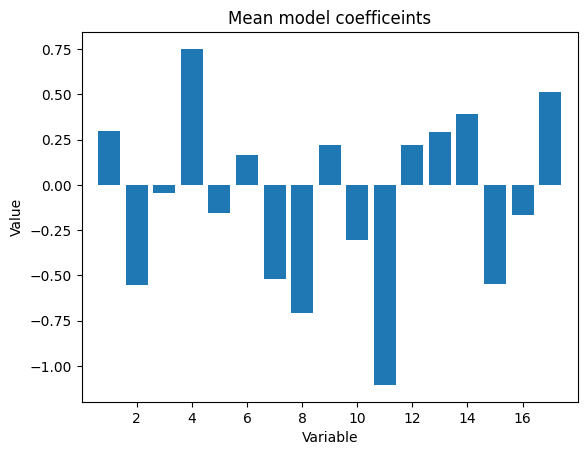

Classification performance for mean coefficient model is 65.0%


In [7]:
# TASK 4
x=np.array(range(1,width+1))
plt.bar(x,meanmodelcoef.flatten())
plt.xticks(range(2,width+1,2),range(2,width+1,2))
plt.xlim([0,width+1])
plt.xlabel("Variable")
plt.ylabel("Value")
plt.title("Mean model coefficeints")
plt.show()

model.coef_=meanmodelcoef
prediction = model.predict(testdata[:,:width])
performance = np.sum(prediction==testdata[:,width])*100/testsize
print("Classification performance for mean coefficient model is "+str(performance)+"%")

In [8]:
# TASK 5
np.random.seed(5)

def remainderstrap(data):
    length = data.shape[0]
    i_array=np.random.randint(length,size=length)
    r_array=np.full((length), True)
    r_array[i_array]=False

    bs = data[i_array]
    remainder = data[r_array]

    return (bs,remainder)


meanmodelcoef = np.zeros((1,width))

attempts = 0
correct_answers = 0

for i in range(200):
    (bs,r)=remainderstrap(data)
    model = sk.linear_model.LogisticRegression().fit(bs[:,:width], bs[:,width])
    meanmodelcoef += model.coef_

    predictions = model.predict(r[:,:width])

    correct_answers += np.sum(predictions == r[:,width])
    attempts += len(predictions)
    
meanmodelcoef/=200
performance = correct_answers/attempts
performance = round(performance*100,2)



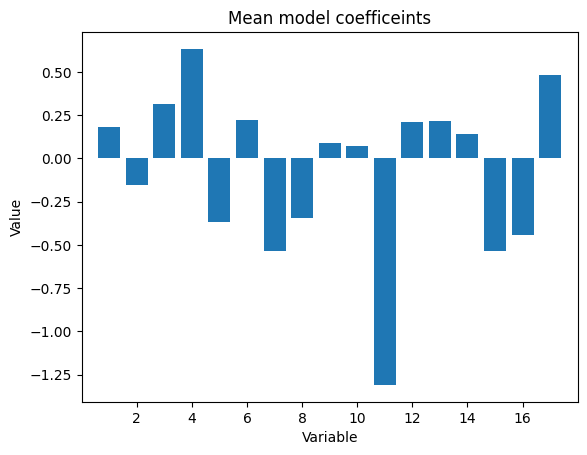

Average performance via out-of-bags evaluation is 65.51%


In [9]:
x=np.array(range(1,width+1))
plt.bar(x,meanmodelcoef.flatten())
plt.xticks(range(2,width+1,2),range(2,width+1,2))
plt.xlim([0,width+1])
plt.xlabel("Variable")
plt.ylabel("Value")
plt.title("Mean model coefficeints")
plt.show()

print("Average performance via out-of-bags evaluation is "+str(performance)+"%")